In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import torchvision
import tqdm
import matplotlib.pyplot as plt
import torch.distributions as dist
import abc

from torch.utils.data import DataLoader
from torch.distributions.distribution import Distribution

from priors import *
from models import *



c:\Users\jorge\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# only run this cell if you use weights and biases for logging
import wandb

wandb.init(project = "BNN_VI", 
            config = {"learning_rate": 0.001,
                      "batch_size": 128,
                      "epochs": 10,
                      "hidden_size": 100,})


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jorgefernando17. Use `wandb login --relogin` to force relogin


In [3]:
# Load MNIST dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
x_train = torch.from_numpy(trainset.data.numpy().reshape(-1, 28*28))/255.
y_train = torch.from_numpy(trainset.targets.numpy())
train_data = torch.utils.data.TensorDataset(x_train, y_train)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
x_test = torch.from_numpy(testset.data.numpy().reshape(-1, 28*28))/255.
y_test = torch.from_numpy(testset.targets.numpy())
test_data = torch.utils.data.TensorDataset(x_test, y_test)


train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


5


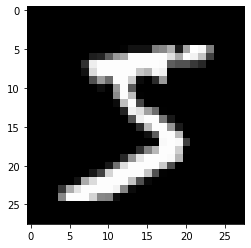

In [4]:
feature = trainset[0][0]
label = trainset[0][1]
print(label)
plt.imshow(feature.squeeze(), cmap='gray')
plt.show()


In [5]:
# create the Bayesian Neural Network
model = Bayesian_Neural_Network(input_dim = 28*28, output_dim = 10, hidden_dims = [100])
print(model)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.95)

# train the model
epochs = 100

for epoch in tqdm.tqdm(range(epochs)):
    for i, (x, y) in enumerate(train_loader):
        # zero the gradients
        optimizer.zero_grad()

        # reshape the data
        x = x.view(-1, 28*28)

        # forward pass
        output, kl_divergence = model(x)

        # compute the loss
        loss = F.nll_loss(F.softmax(output, dim = 1), y, reduction = "sum") + kl_divergence

        # backward pass
        loss.backward()
        optimizer.step()
        
        # accuracy
        acc = torch.mean((torch.argmax(F.softmax(output, dim = 1), dim = 1) == y).float())

        # print the loss
        if i % 100 == 0:
            print(f"Epoch: {epoch} | Batch: {i} | Loss: {loss.item()}, accuracy: {acc.item()}")
            scheduler.step()
            wandb.log({"loss": loss.item(), "accuracy": acc.item(), "epoch": epoch, "batch": i})
            wandb.log({"learning_rate": scheduler.get_lr()[0]})
           
        

  0%|          | 0/100 [00:00<?, ?it/s]

Bayesian_Neural_Network(
  (layers): ModuleList(
    (0): Linear_Layer(
      (weight_prior): Isotropic_Gaussian()
      (bias_prior): Isotropic_Gaussian()
      (weight_posterior): Isotropic_Gaussian()
      (bias_posterior): Isotropic_Gaussian()
    )
    (1): Linear_Layer(
      (weight_prior): Isotropic_Gaussian()
      (bias_prior): Isotropic_Gaussian()
      (weight_posterior): Isotropic_Gaussian()
      (bias_posterior): Isotropic_Gaussian()
    )
  )
)
Epoch: 0 | Batch: 0 | Loss: -11.000992774963379, accuracy: 0.0859375


c:\Users\jorge\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 | Batch: 100 | Loss: -7.022442817687988, accuracy: 0.0859375
Epoch: 0 | Batch: 200 | Loss: -14.150871276855469, accuracy: 0.125
Epoch: 0 | Batch: 300 | Loss: -9.407258987426758, accuracy: 0.078125
Epoch: 0 | Batch: 400 | Loss: -16.880510330200195, accuracy: 0.1328125


  1%|          | 1/100 [00:11<18:57, 11.49s/it]

Epoch: 1 | Batch: 0 | Loss: -17.6046142578125, accuracy: 0.1328125
Epoch: 1 | Batch: 100 | Loss: -13.956823348999023, accuracy: 0.1171875
Epoch: 1 | Batch: 200 | Loss: -7.709478378295898, accuracy: 0.0546875
Epoch: 1 | Batch: 300 | Loss: 2.364556312561035, accuracy: 0.0625
Epoch: 1 | Batch: 400 | Loss: -10.31353759765625, accuracy: 0.1015625


  2%|▏         | 2/100 [00:20<17:20, 10.62s/it]

Epoch: 2 | Batch: 0 | Loss: -8.392467498779297, accuracy: 0.0859375
Epoch: 2 | Batch: 100 | Loss: -9.61220645904541, accuracy: 0.0859375
Epoch: 2 | Batch: 200 | Loss: -11.692599296569824, accuracy: 0.1171875
Epoch: 2 | Batch: 300 | Loss: -13.088478088378906, accuracy: 0.140625
Epoch: 2 | Batch: 400 | Loss: -12.24548625946045, accuracy: 0.1171875


  3%|▎         | 3/100 [00:27<15:26,  9.56s/it]

Epoch: 3 | Batch: 0 | Loss: -13.183349609375, accuracy: 0.125
Epoch: 3 | Batch: 100 | Loss: -12.227880477905273, accuracy: 0.1328125
Epoch: 3 | Batch: 200 | Loss: -7.661340713500977, accuracy: 0.09375
Epoch: 3 | Batch: 300 | Loss: -11.523239135742188, accuracy: 0.125
Epoch: 3 | Batch: 400 | Loss: -14.096150398254395, accuracy: 0.125


  4%|▍         | 4/100 [00:34<14:19,  8.95s/it]

Epoch: 4 | Batch: 0 | Loss: -12.948781967163086, accuracy: 0.09375
Epoch: 4 | Batch: 100 | Loss: -15.297697067260742, accuracy: 0.1484375
Epoch: 4 | Batch: 200 | Loss: -11.76021671295166, accuracy: 0.1015625
Epoch: 4 | Batch: 300 | Loss: -9.481454849243164, accuracy: 0.0703125
Epoch: 4 | Batch: 400 | Loss: -6.739349365234375, accuracy: 0.0703125


  5%|▌         | 5/100 [00:41<13:22,  8.45s/it]

Epoch: 5 | Batch: 0 | Loss: -16.69878387451172, accuracy: 0.140625
Epoch: 5 | Batch: 100 | Loss: -21.870311737060547, accuracy: 0.2109375
Epoch: 5 | Batch: 200 | Loss: -17.650497436523438, accuracy: 0.1640625
Epoch: 5 | Batch: 300 | Loss: -18.257402420043945, accuracy: 0.140625
Epoch: 5 | Batch: 400 | Loss: -5.530156135559082, accuracy: 0.0625


  6%|▌         | 6/100 [00:49<12:38,  8.07s/it]

Epoch: 6 | Batch: 0 | Loss: -8.692289352416992, accuracy: 0.0703125
Epoch: 6 | Batch: 100 | Loss: -19.110538482666016, accuracy: 0.1640625
Epoch: 6 | Batch: 200 | Loss: -5.862171173095703, accuracy: 0.0859375
Epoch: 6 | Batch: 300 | Loss: -8.192596435546875, accuracy: 0.0625
Epoch: 6 | Batch: 400 | Loss: -15.199689865112305, accuracy: 0.109375


  7%|▋         | 7/100 [00:56<12:12,  7.88s/it]

Epoch: 7 | Batch: 0 | Loss: -19.486339569091797, accuracy: 0.171875
Epoch: 7 | Batch: 100 | Loss: -8.745096206665039, accuracy: 0.078125
Epoch: 7 | Batch: 200 | Loss: -17.595905303955078, accuracy: 0.15625
Epoch: 7 | Batch: 300 | Loss: -9.386944770812988, accuracy: 0.0859375
Epoch: 7 | Batch: 400 | Loss: -26.248882293701172, accuracy: 0.25


  8%|▊         | 8/100 [01:04<12:03,  7.87s/it]

Epoch: 8 | Batch: 0 | Loss: -5.916015625, accuracy: 0.0625
Epoch: 8 | Batch: 100 | Loss: -8.91176986694336, accuracy: 0.0859375
Epoch: 8 | Batch: 200 | Loss: -19.007659912109375, accuracy: 0.15625
Epoch: 8 | Batch: 300 | Loss: -9.494194030761719, accuracy: 0.09375
Epoch: 8 | Batch: 400 | Loss: -12.664801597595215, accuracy: 0.109375


  9%|▉         | 9/100 [01:12<11:48,  7.78s/it]

Epoch: 9 | Batch: 0 | Loss: -13.627638816833496, accuracy: 0.109375
Epoch: 9 | Batch: 100 | Loss: -10.303196907043457, accuracy: 0.0859375
Epoch: 9 | Batch: 200 | Loss: -8.029396057128906, accuracy: 0.078125
Epoch: 9 | Batch: 300 | Loss: -15.70711898803711, accuracy: 0.125
Epoch: 9 | Batch: 400 | Loss: -13.987346649169922, accuracy: 0.125


 10%|█         | 10/100 [01:24<13:45,  9.17s/it]

Epoch: 10 | Batch: 0 | Loss: -6.096976280212402, accuracy: 0.0625
Epoch: 10 | Batch: 100 | Loss: -17.965896606445312, accuracy: 0.1484375
Epoch: 10 | Batch: 200 | Loss: -8.999873161315918, accuracy: 0.078125
Epoch: 10 | Batch: 300 | Loss: -8.139886856079102, accuracy: 0.0703125
Epoch: 10 | Batch: 400 | Loss: -23.920860290527344, accuracy: 0.1875


 11%|█         | 11/100 [01:33<13:23,  9.03s/it]

Epoch: 11 | Batch: 0 | Loss: -18.843704223632812, accuracy: 0.1796875
Epoch: 11 | Batch: 100 | Loss: -12.324560165405273, accuracy: 0.09375
Epoch: 11 | Batch: 200 | Loss: -13.168439865112305, accuracy: 0.1171875
Epoch: 11 | Batch: 300 | Loss: -4.805567741394043, accuracy: 0.0625
Epoch: 11 | Batch: 400 | Loss: -15.94833755493164, accuracy: 0.125


 12%|█▏        | 12/100 [01:41<12:44,  8.69s/it]

Epoch: 12 | Batch: 0 | Loss: -12.220210075378418, accuracy: 0.1015625
Epoch: 12 | Batch: 100 | Loss: -6.138446807861328, accuracy: 0.0625
Epoch: 12 | Batch: 200 | Loss: -13.45590591430664, accuracy: 0.1328125
Epoch: 12 | Batch: 300 | Loss: -12.54539680480957, accuracy: 0.125
Epoch: 12 | Batch: 400 | Loss: -29.385400772094727, accuracy: 0.234375


 13%|█▎        | 13/100 [01:48<12:01,  8.29s/it]

Epoch: 13 | Batch: 0 | Loss: -16.010746002197266, accuracy: 0.140625
Epoch: 13 | Batch: 100 | Loss: -10.679491996765137, accuracy: 0.1015625
Epoch: 13 | Batch: 200 | Loss: -10.518824577331543, accuracy: 0.0859375
Epoch: 13 | Batch: 300 | Loss: -12.622148513793945, accuracy: 0.1015625
Epoch: 13 | Batch: 400 | Loss: -14.198951721191406, accuracy: 0.1328125


 14%|█▍        | 14/100 [01:55<11:30,  8.03s/it]

Epoch: 14 | Batch: 0 | Loss: -19.891468048095703, accuracy: 0.1640625
Epoch: 14 | Batch: 100 | Loss: -14.723339080810547, accuracy: 0.1015625
Epoch: 14 | Batch: 200 | Loss: -19.168291091918945, accuracy: 0.1640625
Epoch: 14 | Batch: 300 | Loss: -21.623641967773438, accuracy: 0.1796875
Epoch: 14 | Batch: 400 | Loss: -15.811737060546875, accuracy: 0.1484375


 15%|█▌        | 15/100 [02:03<11:09,  7.88s/it]

Epoch: 15 | Batch: 0 | Loss: -11.240764617919922, accuracy: 0.109375
Epoch: 15 | Batch: 100 | Loss: -15.355558395385742, accuracy: 0.1328125
Epoch: 15 | Batch: 200 | Loss: -13.785198211669922, accuracy: 0.1015625
Epoch: 15 | Batch: 300 | Loss: -23.397560119628906, accuracy: 0.1953125
Epoch: 15 | Batch: 400 | Loss: -11.145977020263672, accuracy: 0.109375


 16%|█▌        | 16/100 [02:10<10:45,  7.69s/it]

Epoch: 16 | Batch: 0 | Loss: -10.732177734375, accuracy: 0.125
Epoch: 16 | Batch: 100 | Loss: -8.887267112731934, accuracy: 0.09375
Epoch: 16 | Batch: 200 | Loss: -10.351566314697266, accuracy: 0.1171875
Epoch: 16 | Batch: 300 | Loss: -22.558189392089844, accuracy: 0.1796875
Epoch: 16 | Batch: 400 | Loss: -14.643133163452148, accuracy: 0.1484375


 17%|█▋        | 17/100 [02:17<10:23,  7.51s/it]

Epoch: 17 | Batch: 0 | Loss: -20.31273651123047, accuracy: 0.1875
Epoch: 17 | Batch: 100 | Loss: -14.6793212890625, accuracy: 0.1328125
Epoch: 17 | Batch: 200 | Loss: -12.266656875610352, accuracy: 0.140625
Epoch: 17 | Batch: 300 | Loss: -14.900556564331055, accuracy: 0.125
Epoch: 17 | Batch: 400 | Loss: -16.68642807006836, accuracy: 0.1328125


 18%|█▊        | 18/100 [02:25<10:17,  7.53s/it]

Epoch: 18 | Batch: 0 | Loss: -9.506101608276367, accuracy: 0.0859375
Epoch: 18 | Batch: 100 | Loss: -12.608879089355469, accuracy: 0.1171875
Epoch: 18 | Batch: 200 | Loss: -11.109515190124512, accuracy: 0.09375
Epoch: 18 | Batch: 300 | Loss: -15.345169067382812, accuracy: 0.125
Epoch: 18 | Batch: 400 | Loss: -27.176471710205078, accuracy: 0.265625


 19%|█▉        | 19/100 [02:32<10:01,  7.43s/it]

Epoch: 19 | Batch: 0 | Loss: -5.397665023803711, accuracy: 0.046875
Epoch: 19 | Batch: 100 | Loss: -12.800684928894043, accuracy: 0.1171875
Epoch: 19 | Batch: 200 | Loss: -13.38730239868164, accuracy: 0.125
Epoch: 19 | Batch: 300 | Loss: -15.205207824707031, accuracy: 0.1484375
Epoch: 19 | Batch: 400 | Loss: -10.085851669311523, accuracy: 0.1015625


 20%|██        | 20/100 [02:39<09:54,  7.44s/it]

Epoch: 20 | Batch: 0 | Loss: -12.217430114746094, accuracy: 0.0703125
Epoch: 20 | Batch: 100 | Loss: -14.326576232910156, accuracy: 0.1171875
Epoch: 20 | Batch: 200 | Loss: -9.760246276855469, accuracy: 0.09375
Epoch: 20 | Batch: 300 | Loss: -12.368890762329102, accuracy: 0.109375
Epoch: 20 | Batch: 400 | Loss: -6.027953624725342, accuracy: 0.0625


 21%|██        | 21/100 [02:47<09:45,  7.41s/it]

Epoch: 21 | Batch: 0 | Loss: -10.463932037353516, accuracy: 0.109375
Epoch: 21 | Batch: 100 | Loss: -7.924627304077148, accuracy: 0.0703125
Epoch: 21 | Batch: 200 | Loss: -22.1498966217041, accuracy: 0.2109375
Epoch: 21 | Batch: 300 | Loss: -13.416160583496094, accuracy: 0.109375
Epoch: 21 | Batch: 400 | Loss: -14.065425872802734, accuracy: 0.1328125


 22%|██▏       | 22/100 [02:55<09:52,  7.60s/it]

Epoch: 22 | Batch: 0 | Loss: -24.756263732910156, accuracy: 0.1875
Epoch: 22 | Batch: 100 | Loss: -24.636497497558594, accuracy: 0.2109375
Epoch: 22 | Batch: 200 | Loss: -21.226972579956055, accuracy: 0.171875
Epoch: 22 | Batch: 300 | Loss: -17.30094337463379, accuracy: 0.171875
Epoch: 22 | Batch: 400 | Loss: -6.204425811767578, accuracy: 0.0625


 23%|██▎       | 23/100 [03:02<09:33,  7.45s/it]

Epoch: 23 | Batch: 0 | Loss: -7.945798873901367, accuracy: 0.0625
Epoch: 23 | Batch: 100 | Loss: -14.000104904174805, accuracy: 0.140625
Epoch: 23 | Batch: 200 | Loss: -14.431159973144531, accuracy: 0.1328125
Epoch: 23 | Batch: 300 | Loss: -14.928550720214844, accuracy: 0.125
Epoch: 23 | Batch: 400 | Loss: -18.846628189086914, accuracy: 0.1484375


 24%|██▍       | 24/100 [03:09<09:18,  7.35s/it]

Epoch: 24 | Batch: 0 | Loss: -18.685325622558594, accuracy: 0.1640625
Epoch: 24 | Batch: 100 | Loss: -11.468804359436035, accuracy: 0.09375
Epoch: 24 | Batch: 200 | Loss: -14.700080871582031, accuracy: 0.125
Epoch: 24 | Batch: 300 | Loss: -13.087178230285645, accuracy: 0.109375
Epoch: 24 | Batch: 400 | Loss: -22.074281692504883, accuracy: 0.203125


 25%|██▌       | 25/100 [03:16<08:55,  7.14s/it]

Epoch: 25 | Batch: 0 | Loss: -8.854936599731445, accuracy: 0.0859375
Epoch: 25 | Batch: 100 | Loss: -15.138254165649414, accuracy: 0.125
Epoch: 25 | Batch: 200 | Loss: -18.64626693725586, accuracy: 0.1640625
Epoch: 25 | Batch: 300 | Loss: -18.90910530090332, accuracy: 0.15625
Epoch: 25 | Batch: 400 | Loss: -15.712574005126953, accuracy: 0.125


 26%|██▌       | 26/100 [03:23<08:46,  7.11s/it]

Epoch: 26 | Batch: 0 | Loss: -15.511003494262695, accuracy: 0.140625
Epoch: 26 | Batch: 100 | Loss: -14.72723388671875, accuracy: 0.125
Epoch: 26 | Batch: 200 | Loss: -26.815824508666992, accuracy: 0.234375
Epoch: 26 | Batch: 300 | Loss: -21.81354522705078, accuracy: 0.15625
Epoch: 26 | Batch: 400 | Loss: -15.382884979248047, accuracy: 0.125


 27%|██▋       | 27/100 [03:30<08:37,  7.08s/it]

Epoch: 27 | Batch: 0 | Loss: -16.053510665893555, accuracy: 0.125
Epoch: 27 | Batch: 100 | Loss: -12.543367385864258, accuracy: 0.1328125
Epoch: 27 | Batch: 200 | Loss: -11.51837158203125, accuracy: 0.109375
Epoch: 27 | Batch: 300 | Loss: -20.219593048095703, accuracy: 0.2109375
Epoch: 27 | Batch: 400 | Loss: -15.628047943115234, accuracy: 0.1328125


 28%|██▊       | 28/100 [03:37<08:29,  7.07s/it]

Epoch: 28 | Batch: 0 | Loss: -13.464073181152344, accuracy: 0.1328125
Epoch: 28 | Batch: 100 | Loss: -28.18380355834961, accuracy: 0.265625
Epoch: 28 | Batch: 200 | Loss: -24.157737731933594, accuracy: 0.21875
Epoch: 28 | Batch: 300 | Loss: -17.227014541625977, accuracy: 0.1640625
Epoch: 28 | Batch: 400 | Loss: -6.443997383117676, accuracy: 0.0546875


 29%|██▉       | 29/100 [03:44<08:17,  7.00s/it]

Epoch: 29 | Batch: 0 | Loss: -14.167141914367676, accuracy: 0.109375
Epoch: 29 | Batch: 100 | Loss: -4.501863479614258, accuracy: 0.03125
Epoch: 29 | Batch: 200 | Loss: -19.580102920532227, accuracy: 0.1953125
Epoch: 29 | Batch: 300 | Loss: -14.495620727539062, accuracy: 0.1484375
Epoch: 29 | Batch: 400 | Loss: -5.803635597229004, accuracy: 0.0703125


 30%|███       | 30/100 [03:51<08:09,  7.00s/it]

Epoch: 30 | Batch: 0 | Loss: -11.621553421020508, accuracy: 0.140625
Epoch: 30 | Batch: 100 | Loss: -10.034173011779785, accuracy: 0.0859375
Epoch: 30 | Batch: 200 | Loss: -17.853302001953125, accuracy: 0.15625
Epoch: 30 | Batch: 300 | Loss: -23.32671546936035, accuracy: 0.1875
Epoch: 30 | Batch: 400 | Loss: -9.51809310913086, accuracy: 0.0703125


 31%|███       | 31/100 [03:58<08:06,  7.05s/it]

Epoch: 31 | Batch: 0 | Loss: -7.203341484069824, accuracy: 0.0625
Epoch: 31 | Batch: 100 | Loss: -7.566451072692871, accuracy: 0.0703125
Epoch: 31 | Batch: 200 | Loss: -12.188393592834473, accuracy: 0.1171875
Epoch: 31 | Batch: 300 | Loss: -15.556648254394531, accuracy: 0.125
Epoch: 31 | Batch: 400 | Loss: -13.730467796325684, accuracy: 0.125


 32%|███▏      | 32/100 [04:04<07:51,  6.93s/it]

Epoch: 32 | Batch: 0 | Loss: -12.176512718200684, accuracy: 0.0859375
Epoch: 32 | Batch: 100 | Loss: -14.766717910766602, accuracy: 0.1171875
Epoch: 32 | Batch: 200 | Loss: -9.38098430633545, accuracy: 0.0625
Epoch: 32 | Batch: 300 | Loss: -11.783092498779297, accuracy: 0.0859375
Epoch: 32 | Batch: 400 | Loss: -12.991943359375, accuracy: 0.1015625


 33%|███▎      | 33/100 [04:11<07:45,  6.95s/it]

Epoch: 33 | Batch: 0 | Loss: -14.449657440185547, accuracy: 0.109375
Epoch: 33 | Batch: 100 | Loss: -13.78965950012207, accuracy: 0.1328125
Epoch: 33 | Batch: 200 | Loss: -5.453349590301514, accuracy: 0.0625
Epoch: 33 | Batch: 300 | Loss: -8.956154823303223, accuracy: 0.0859375
Epoch: 33 | Batch: 400 | Loss: -10.040572166442871, accuracy: 0.09375


 34%|███▍      | 34/100 [04:18<07:35,  6.91s/it]

Epoch: 34 | Batch: 0 | Loss: -15.776521682739258, accuracy: 0.140625
Epoch: 34 | Batch: 100 | Loss: -5.956907272338867, accuracy: 0.0546875
Epoch: 34 | Batch: 200 | Loss: -8.621173858642578, accuracy: 0.0703125
Epoch: 34 | Batch: 300 | Loss: -15.230274200439453, accuracy: 0.125
Epoch: 34 | Batch: 400 | Loss: -12.815007209777832, accuracy: 0.1171875


 35%|███▌      | 35/100 [04:25<07:28,  6.90s/it]

Epoch: 35 | Batch: 0 | Loss: -18.835372924804688, accuracy: 0.171875
Epoch: 35 | Batch: 100 | Loss: -11.797779083251953, accuracy: 0.15625
Epoch: 35 | Batch: 200 | Loss: -21.464494705200195, accuracy: 0.171875
Epoch: 35 | Batch: 300 | Loss: -14.628849029541016, accuracy: 0.0859375
Epoch: 35 | Batch: 400 | Loss: -9.237282752990723, accuracy: 0.0859375


 36%|███▌      | 36/100 [04:32<07:18,  6.85s/it]

Epoch: 36 | Batch: 0 | Loss: -9.744697570800781, accuracy: 0.078125
Epoch: 36 | Batch: 100 | Loss: -13.89825439453125, accuracy: 0.1171875
Epoch: 36 | Batch: 200 | Loss: -21.814346313476562, accuracy: 0.1875
Epoch: 36 | Batch: 300 | Loss: -21.41326904296875, accuracy: 0.1796875
Epoch: 36 | Batch: 400 | Loss: -23.938274383544922, accuracy: 0.171875


 37%|███▋      | 37/100 [04:39<07:09,  6.81s/it]

Epoch: 37 | Batch: 0 | Loss: -17.332115173339844, accuracy: 0.1484375
Epoch: 37 | Batch: 100 | Loss: -15.430024147033691, accuracy: 0.109375
Epoch: 37 | Batch: 200 | Loss: -8.809785842895508, accuracy: 0.078125
Epoch: 37 | Batch: 300 | Loss: -18.802547454833984, accuracy: 0.171875
Epoch: 37 | Batch: 400 | Loss: -25.53315544128418, accuracy: 0.2265625


 38%|███▊      | 38/100 [04:46<07:05,  6.86s/it]

Epoch: 38 | Batch: 0 | Loss: -5.351572036743164, accuracy: 0.0390625
Epoch: 38 | Batch: 100 | Loss: -1.1637978553771973, accuracy: 0.0390625
Epoch: 38 | Batch: 200 | Loss: -21.525270462036133, accuracy: 0.1796875
Epoch: 38 | Batch: 300 | Loss: -15.957592010498047, accuracy: 0.1484375
Epoch: 38 | Batch: 400 | Loss: -13.835577964782715, accuracy: 0.09375


 39%|███▉      | 39/100 [04:52<06:58,  6.87s/it]

Epoch: 39 | Batch: 0 | Loss: -14.177600860595703, accuracy: 0.1328125
Epoch: 39 | Batch: 100 | Loss: -19.755199432373047, accuracy: 0.171875
Epoch: 39 | Batch: 200 | Loss: -12.661256790161133, accuracy: 0.1171875
Epoch: 39 | Batch: 300 | Loss: -6.058202266693115, accuracy: 0.0546875
Epoch: 39 | Batch: 400 | Loss: -18.271644592285156, accuracy: 0.171875


 40%|████      | 40/100 [04:59<06:52,  6.88s/it]

Epoch: 40 | Batch: 0 | Loss: -20.113285064697266, accuracy: 0.1875
Epoch: 40 | Batch: 100 | Loss: -13.442161560058594, accuracy: 0.125
Epoch: 40 | Batch: 200 | Loss: -18.352855682373047, accuracy: 0.1484375
Epoch: 40 | Batch: 300 | Loss: -12.444355964660645, accuracy: 0.1171875
Epoch: 40 | Batch: 400 | Loss: -18.547313690185547, accuracy: 0.171875


 41%|████      | 41/100 [05:06<06:47,  6.90s/it]

Epoch: 41 | Batch: 0 | Loss: -23.92498016357422, accuracy: 0.2109375
Epoch: 41 | Batch: 100 | Loss: -20.693260192871094, accuracy: 0.171875
Epoch: 41 | Batch: 200 | Loss: -12.555130004882812, accuracy: 0.09375
Epoch: 41 | Batch: 300 | Loss: -14.795293807983398, accuracy: 0.15625
Epoch: 41 | Batch: 400 | Loss: -6.212269306182861, accuracy: 0.046875


 42%|████▏     | 42/100 [05:13<06:39,  6.89s/it]

Epoch: 42 | Batch: 0 | Loss: -18.569276809692383, accuracy: 0.140625
Epoch: 42 | Batch: 100 | Loss: -10.007043838500977, accuracy: 0.1015625
Epoch: 42 | Batch: 200 | Loss: -12.78146743774414, accuracy: 0.109375
Epoch: 42 | Batch: 300 | Loss: -13.886476516723633, accuracy: 0.1328125
Epoch: 42 | Batch: 400 | Loss: -14.679830551147461, accuracy: 0.1328125


 43%|████▎     | 43/100 [05:20<06:30,  6.85s/it]

Epoch: 43 | Batch: 0 | Loss: -11.42205810546875, accuracy: 0.0859375
Epoch: 43 | Batch: 100 | Loss: -15.576946258544922, accuracy: 0.109375
Epoch: 43 | Batch: 200 | Loss: -16.105802536010742, accuracy: 0.15625
Epoch: 43 | Batch: 300 | Loss: -11.015220642089844, accuracy: 0.0859375
Epoch: 43 | Batch: 400 | Loss: -16.676063537597656, accuracy: 0.140625


 44%|████▍     | 44/100 [05:27<06:23,  6.84s/it]

Epoch: 44 | Batch: 0 | Loss: -16.318492889404297, accuracy: 0.1328125
Epoch: 44 | Batch: 100 | Loss: -13.288816452026367, accuracy: 0.125
Epoch: 44 | Batch: 200 | Loss: -9.535526275634766, accuracy: 0.0859375
Epoch: 44 | Batch: 300 | Loss: -11.088486671447754, accuracy: 0.078125
Epoch: 44 | Batch: 400 | Loss: -16.72355842590332, accuracy: 0.1484375


 45%|████▌     | 45/100 [05:34<06:15,  6.83s/it]

Epoch: 45 | Batch: 0 | Loss: -7.392782211303711, accuracy: 0.0703125
Epoch: 45 | Batch: 100 | Loss: -19.00523567199707, accuracy: 0.171875
Epoch: 45 | Batch: 200 | Loss: -14.60396957397461, accuracy: 0.1328125
Epoch: 45 | Batch: 300 | Loss: -10.957635879516602, accuracy: 0.125
Epoch: 45 | Batch: 400 | Loss: -8.152144432067871, accuracy: 0.078125


 46%|████▌     | 46/100 [05:40<06:04,  6.75s/it]

Epoch: 46 | Batch: 0 | Loss: -21.627105712890625, accuracy: 0.2265625
Epoch: 46 | Batch: 100 | Loss: -6.924679756164551, accuracy: 0.0546875
Epoch: 46 | Batch: 200 | Loss: -7.649819374084473, accuracy: 0.0859375
Epoch: 46 | Batch: 300 | Loss: -17.474811553955078, accuracy: 0.171875
Epoch: 46 | Batch: 400 | Loss: -14.334793090820312, accuracy: 0.1328125


 47%|████▋     | 47/100 [05:47<05:58,  6.76s/it]

Epoch: 47 | Batch: 0 | Loss: -10.922286987304688, accuracy: 0.1171875
Epoch: 47 | Batch: 100 | Loss: -14.567626953125, accuracy: 0.140625
Epoch: 47 | Batch: 200 | Loss: -21.344013214111328, accuracy: 0.171875
Epoch: 47 | Batch: 300 | Loss: -10.131349563598633, accuracy: 0.0703125
Epoch: 47 | Batch: 400 | Loss: -21.07659912109375, accuracy: 0.1640625


 48%|████▊     | 48/100 [05:54<05:51,  6.75s/it]

Epoch: 48 | Batch: 0 | Loss: -10.65074348449707, accuracy: 0.09375
Epoch: 48 | Batch: 100 | Loss: -19.933574676513672, accuracy: 0.1640625
Epoch: 48 | Batch: 200 | Loss: -19.51718521118164, accuracy: 0.1640625
Epoch: 48 | Batch: 300 | Loss: -8.6270751953125, accuracy: 0.078125
Epoch: 48 | Batch: 400 | Loss: -15.894718170166016, accuracy: 0.125


 49%|████▉     | 49/100 [06:00<05:44,  6.75s/it]

Epoch: 49 | Batch: 0 | Loss: -10.157020568847656, accuracy: 0.0625
Epoch: 49 | Batch: 100 | Loss: -1.9983019828796387, accuracy: 0.03125
Epoch: 49 | Batch: 200 | Loss: -12.983750343322754, accuracy: 0.109375
Epoch: 49 | Batch: 300 | Loss: -14.62283706665039, accuracy: 0.1328125
Epoch: 49 | Batch: 400 | Loss: -21.390390396118164, accuracy: 0.1875


 50%|█████     | 50/100 [06:07<05:38,  6.76s/it]

Epoch: 50 | Batch: 0 | Loss: -10.718670845031738, accuracy: 0.09375
Epoch: 50 | Batch: 100 | Loss: -11.753345489501953, accuracy: 0.09375
Epoch: 50 | Batch: 200 | Loss: -8.993082046508789, accuracy: 0.1015625
Epoch: 50 | Batch: 300 | Loss: -18.11920166015625, accuracy: 0.1640625
Epoch: 50 | Batch: 400 | Loss: -13.850057601928711, accuracy: 0.125


 51%|█████     | 51/100 [06:14<05:32,  6.79s/it]

Epoch: 51 | Batch: 0 | Loss: -21.536357879638672, accuracy: 0.1640625
Epoch: 51 | Batch: 100 | Loss: -20.73232650756836, accuracy: 0.171875
Epoch: 51 | Batch: 200 | Loss: -8.413021087646484, accuracy: 0.0625
Epoch: 51 | Batch: 300 | Loss: -23.199474334716797, accuracy: 0.203125
Epoch: 51 | Batch: 400 | Loss: -27.997207641601562, accuracy: 0.25


 52%|█████▏    | 52/100 [06:21<05:24,  6.76s/it]

Epoch: 52 | Batch: 0 | Loss: -18.976810455322266, accuracy: 0.171875
Epoch: 52 | Batch: 100 | Loss: -28.059803009033203, accuracy: 0.21875
Epoch: 52 | Batch: 200 | Loss: -8.706918716430664, accuracy: 0.109375
Epoch: 52 | Batch: 300 | Loss: -4.204435348510742, accuracy: 0.046875
Epoch: 52 | Batch: 400 | Loss: -8.124460220336914, accuracy: 0.0859375


 53%|█████▎    | 53/100 [06:27<05:18,  6.77s/it]

Epoch: 53 | Batch: 0 | Loss: -13.799468040466309, accuracy: 0.1171875
Epoch: 53 | Batch: 100 | Loss: -22.001497268676758, accuracy: 0.1875
Epoch: 53 | Batch: 200 | Loss: -11.618376731872559, accuracy: 0.109375
Epoch: 53 | Batch: 300 | Loss: -18.330322265625, accuracy: 0.1640625
Epoch: 53 | Batch: 400 | Loss: -10.693530082702637, accuracy: 0.0859375


 54%|█████▍    | 54/100 [06:34<05:13,  6.81s/it]

Epoch: 54 | Batch: 0 | Loss: -16.915973663330078, accuracy: 0.1328125
Epoch: 54 | Batch: 100 | Loss: -23.202871322631836, accuracy: 0.1875
Epoch: 54 | Batch: 200 | Loss: -12.910569190979004, accuracy: 0.09375
Epoch: 54 | Batch: 300 | Loss: -20.688072204589844, accuracy: 0.171875
Epoch: 54 | Batch: 400 | Loss: -13.140134811401367, accuracy: 0.109375


 55%|█████▌    | 55/100 [06:41<05:07,  6.83s/it]

Epoch: 55 | Batch: 0 | Loss: -7.5465803146362305, accuracy: 0.09375
Epoch: 55 | Batch: 100 | Loss: -4.7409138679504395, accuracy: 0.0390625
Epoch: 55 | Batch: 200 | Loss: -26.375743865966797, accuracy: 0.203125
Epoch: 55 | Batch: 300 | Loss: -18.245893478393555, accuracy: 0.1640625
Epoch: 55 | Batch: 400 | Loss: -13.29207992553711, accuracy: 0.1171875


 56%|█████▌    | 56/100 [06:48<04:57,  6.76s/it]

Epoch: 56 | Batch: 0 | Loss: -9.366585731506348, accuracy: 0.046875
Epoch: 56 | Batch: 100 | Loss: -7.489635467529297, accuracy: 0.0859375
Epoch: 56 | Batch: 200 | Loss: -11.5491943359375, accuracy: 0.109375
Epoch: 56 | Batch: 300 | Loss: -14.011615753173828, accuracy: 0.1328125
Epoch: 56 | Batch: 400 | Loss: -13.62752628326416, accuracy: 0.1171875


 57%|█████▋    | 57/100 [06:55<04:55,  6.88s/it]

Epoch: 57 | Batch: 0 | Loss: -13.5618896484375, accuracy: 0.109375
Epoch: 57 | Batch: 100 | Loss: -11.462998390197754, accuracy: 0.1015625
Epoch: 57 | Batch: 200 | Loss: -20.81547737121582, accuracy: 0.1796875
Epoch: 57 | Batch: 300 | Loss: -17.750110626220703, accuracy: 0.1484375
Epoch: 57 | Batch: 400 | Loss: -5.441149711608887, accuracy: 0.0390625


 58%|█████▊    | 58/100 [07:02<04:51,  6.95s/it]

Epoch: 58 | Batch: 0 | Loss: -18.743623733520508, accuracy: 0.1640625
Epoch: 58 | Batch: 100 | Loss: -17.210458755493164, accuracy: 0.15625
Epoch: 58 | Batch: 200 | Loss: -11.812179565429688, accuracy: 0.1015625
Epoch: 58 | Batch: 300 | Loss: -14.155364990234375, accuracy: 0.1171875
Epoch: 58 | Batch: 400 | Loss: -8.444253921508789, accuracy: 0.078125


 59%|█████▉    | 59/100 [07:09<04:44,  6.94s/it]

Epoch: 59 | Batch: 0 | Loss: -11.315013885498047, accuracy: 0.0859375
Epoch: 59 | Batch: 100 | Loss: -16.81305694580078, accuracy: 0.1484375
Epoch: 59 | Batch: 200 | Loss: -11.287654876708984, accuracy: 0.1015625
Epoch: 59 | Batch: 300 | Loss: -22.25996208190918, accuracy: 0.1796875
Epoch: 59 | Batch: 400 | Loss: -18.860239028930664, accuracy: 0.1796875


 60%|██████    | 60/100 [07:16<04:35,  6.89s/it]

Epoch: 60 | Batch: 0 | Loss: -17.96417999267578, accuracy: 0.171875
Epoch: 60 | Batch: 100 | Loss: -12.529685974121094, accuracy: 0.140625
Epoch: 60 | Batch: 200 | Loss: -14.522289276123047, accuracy: 0.1484375
Epoch: 60 | Batch: 300 | Loss: -11.46631908416748, accuracy: 0.09375
Epoch: 60 | Batch: 400 | Loss: -10.117514610290527, accuracy: 0.09375


 61%|██████    | 61/100 [07:23<04:30,  6.93s/it]

Epoch: 61 | Batch: 0 | Loss: -12.88140869140625, accuracy: 0.125
Epoch: 61 | Batch: 100 | Loss: -13.546144485473633, accuracy: 0.1328125
Epoch: 61 | Batch: 200 | Loss: -17.66071319580078, accuracy: 0.15625
Epoch: 61 | Batch: 300 | Loss: -19.37429428100586, accuracy: 0.1640625
Epoch: 61 | Batch: 400 | Loss: -12.794722557067871, accuracy: 0.1171875


 62%|██████▏   | 62/100 [07:30<04:21,  6.89s/it]

Epoch: 62 | Batch: 0 | Loss: -17.18125343322754, accuracy: 0.1640625
Epoch: 62 | Batch: 100 | Loss: -15.168495178222656, accuracy: 0.140625
Epoch: 62 | Batch: 200 | Loss: -18.06283187866211, accuracy: 0.15625
Epoch: 62 | Batch: 300 | Loss: -18.31951904296875, accuracy: 0.1328125
Epoch: 62 | Batch: 400 | Loss: -8.798666000366211, accuracy: 0.109375


 63%|██████▎   | 63/100 [07:36<04:12,  6.83s/it]

Epoch: 63 | Batch: 0 | Loss: -22.126407623291016, accuracy: 0.1796875
Epoch: 63 | Batch: 100 | Loss: -8.38632869720459, accuracy: 0.0859375
Epoch: 63 | Batch: 200 | Loss: -18.931135177612305, accuracy: 0.1484375
Epoch: 63 | Batch: 300 | Loss: -19.673301696777344, accuracy: 0.1484375
Epoch: 63 | Batch: 400 | Loss: -15.08169174194336, accuracy: 0.140625


 64%|██████▍   | 64/100 [07:43<04:05,  6.81s/it]

Epoch: 64 | Batch: 0 | Loss: -11.652820587158203, accuracy: 0.09375
Epoch: 64 | Batch: 100 | Loss: -16.531084060668945, accuracy: 0.1484375
Epoch: 64 | Batch: 200 | Loss: -18.074710845947266, accuracy: 0.1640625
Epoch: 64 | Batch: 300 | Loss: -8.984396934509277, accuracy: 0.0703125
Epoch: 64 | Batch: 400 | Loss: -17.44915771484375, accuracy: 0.1796875


 65%|██████▌   | 65/100 [07:50<04:00,  6.87s/it]

Epoch: 65 | Batch: 0 | Loss: -11.514875411987305, accuracy: 0.09375
Epoch: 65 | Batch: 100 | Loss: -18.583866119384766, accuracy: 0.1484375
Epoch: 65 | Batch: 200 | Loss: -11.0751953125, accuracy: 0.0859375
Epoch: 65 | Batch: 300 | Loss: -14.767345428466797, accuracy: 0.1328125
Epoch: 65 | Batch: 400 | Loss: -15.410255432128906, accuracy: 0.125


 66%|██████▌   | 66/100 [07:57<03:55,  6.91s/it]

Epoch: 66 | Batch: 0 | Loss: -10.364431381225586, accuracy: 0.0703125
Epoch: 66 | Batch: 100 | Loss: -7.561359882354736, accuracy: 0.0625
Epoch: 66 | Batch: 200 | Loss: -8.732539176940918, accuracy: 0.0859375
Epoch: 66 | Batch: 300 | Loss: -20.16139030456543, accuracy: 0.171875
Epoch: 66 | Batch: 400 | Loss: -7.409611701965332, accuracy: 0.0703125


 67%|██████▋   | 67/100 [08:04<03:45,  6.84s/it]

Epoch: 67 | Batch: 0 | Loss: -13.826622009277344, accuracy: 0.140625
Epoch: 67 | Batch: 100 | Loss: -10.359102249145508, accuracy: 0.09375
Epoch: 67 | Batch: 200 | Loss: -13.406373977661133, accuracy: 0.109375
Epoch: 67 | Batch: 300 | Loss: -6.118865013122559, accuracy: 0.0625
Epoch: 67 | Batch: 400 | Loss: -7.402041435241699, accuracy: 0.0546875


 68%|██████▊   | 68/100 [08:10<03:37,  6.79s/it]

Epoch: 68 | Batch: 0 | Loss: -32.40606689453125, accuracy: 0.2734375
Epoch: 68 | Batch: 100 | Loss: -9.713183403015137, accuracy: 0.0859375
Epoch: 68 | Batch: 200 | Loss: -8.324995994567871, accuracy: 0.0859375
Epoch: 68 | Batch: 300 | Loss: -6.291095733642578, accuracy: 0.0625
Epoch: 68 | Batch: 400 | Loss: -25.079875946044922, accuracy: 0.21875


 69%|██████▉   | 69/100 [08:17<03:29,  6.75s/it]

Epoch: 69 | Batch: 0 | Loss: -9.426897048950195, accuracy: 0.09375
Epoch: 69 | Batch: 100 | Loss: -16.652847290039062, accuracy: 0.125
Epoch: 69 | Batch: 200 | Loss: -15.883843421936035, accuracy: 0.125
Epoch: 69 | Batch: 300 | Loss: -7.391256332397461, accuracy: 0.0234375
Epoch: 69 | Batch: 400 | Loss: -13.42354679107666, accuracy: 0.1015625


 70%|███████   | 70/100 [08:24<03:20,  6.69s/it]

Epoch: 70 | Batch: 0 | Loss: -12.859512329101562, accuracy: 0.1171875
Epoch: 70 | Batch: 100 | Loss: -18.89632225036621, accuracy: 0.171875
Epoch: 70 | Batch: 200 | Loss: -16.53759002685547, accuracy: 0.1328125
Epoch: 70 | Batch: 300 | Loss: -22.666961669921875, accuracy: 0.2109375
Epoch: 70 | Batch: 400 | Loss: -13.267675399780273, accuracy: 0.109375


 71%|███████   | 71/100 [08:30<03:13,  6.68s/it]

Epoch: 71 | Batch: 0 | Loss: -10.348739624023438, accuracy: 0.1328125
Epoch: 71 | Batch: 100 | Loss: -9.426982879638672, accuracy: 0.109375
Epoch: 71 | Batch: 200 | Loss: -10.55501651763916, accuracy: 0.09375
Epoch: 71 | Batch: 300 | Loss: -8.7730712890625, accuracy: 0.0703125
Epoch: 71 | Batch: 400 | Loss: -7.701140403747559, accuracy: 0.078125


 72%|███████▏  | 72/100 [08:37<03:07,  6.70s/it]

Epoch: 72 | Batch: 0 | Loss: -11.300347328186035, accuracy: 0.109375
Epoch: 72 | Batch: 100 | Loss: -26.264434814453125, accuracy: 0.2265625
Epoch: 72 | Batch: 200 | Loss: -12.000932693481445, accuracy: 0.0625
Epoch: 72 | Batch: 300 | Loss: -8.791807174682617, accuracy: 0.1015625
Epoch: 72 | Batch: 400 | Loss: -19.779911041259766, accuracy: 0.1875


 73%|███████▎  | 73/100 [08:44<03:01,  6.73s/it]

Epoch: 73 | Batch: 0 | Loss: -8.993646621704102, accuracy: 0.0703125
Epoch: 73 | Batch: 100 | Loss: -18.36977195739746, accuracy: 0.15625
Epoch: 73 | Batch: 200 | Loss: -13.367431640625, accuracy: 0.1015625
Epoch: 73 | Batch: 300 | Loss: -20.409141540527344, accuracy: 0.1953125
Epoch: 73 | Batch: 400 | Loss: -7.881299018859863, accuracy: 0.078125


 74%|███████▍  | 74/100 [08:51<02:54,  6.71s/it]

Epoch: 74 | Batch: 0 | Loss: -11.285408020019531, accuracy: 0.1171875
Epoch: 74 | Batch: 100 | Loss: -11.949119567871094, accuracy: 0.0859375
Epoch: 74 | Batch: 200 | Loss: -19.346586227416992, accuracy: 0.1875
Epoch: 74 | Batch: 300 | Loss: -16.06092071533203, accuracy: 0.1328125
Epoch: 74 | Batch: 400 | Loss: -14.462614059448242, accuracy: 0.1640625


 75%|███████▌  | 75/100 [08:57<02:46,  6.68s/it]

Epoch: 75 | Batch: 0 | Loss: -9.782276153564453, accuracy: 0.0859375
Epoch: 75 | Batch: 100 | Loss: -6.293338298797607, accuracy: 0.0390625
Epoch: 75 | Batch: 200 | Loss: -20.375869750976562, accuracy: 0.1796875
Epoch: 75 | Batch: 300 | Loss: -16.51569175720215, accuracy: 0.15625
Epoch: 75 | Batch: 400 | Loss: -21.624656677246094, accuracy: 0.1875


 76%|███████▌  | 76/100 [09:03<02:36,  6.53s/it]

Epoch: 76 | Batch: 0 | Loss: -15.173751831054688, accuracy: 0.1484375
Epoch: 76 | Batch: 100 | Loss: -13.304278373718262, accuracy: 0.1015625
Epoch: 76 | Batch: 200 | Loss: -5.882567405700684, accuracy: 0.0703125
Epoch: 76 | Batch: 300 | Loss: -23.039705276489258, accuracy: 0.2109375
Epoch: 76 | Batch: 400 | Loss: -13.946123123168945, accuracy: 0.1328125


 77%|███████▋  | 77/100 [09:10<02:28,  6.44s/it]

Epoch: 77 | Batch: 0 | Loss: -12.65698528289795, accuracy: 0.1171875
Epoch: 77 | Batch: 100 | Loss: -21.384746551513672, accuracy: 0.1640625
Epoch: 77 | Batch: 200 | Loss: -24.013336181640625, accuracy: 0.2265625
Epoch: 77 | Batch: 300 | Loss: -5.1870527267456055, accuracy: 0.046875
Epoch: 77 | Batch: 400 | Loss: -19.022199630737305, accuracy: 0.1640625


 78%|███████▊  | 78/100 [09:16<02:20,  6.39s/it]

Epoch: 78 | Batch: 0 | Loss: -10.183943748474121, accuracy: 0.078125
Epoch: 78 | Batch: 100 | Loss: -17.466716766357422, accuracy: 0.1484375
Epoch: 78 | Batch: 200 | Loss: -21.309600830078125, accuracy: 0.1875
Epoch: 78 | Batch: 300 | Loss: -22.04220199584961, accuracy: 0.171875
Epoch: 78 | Batch: 400 | Loss: -23.327857971191406, accuracy: 0.234375


 79%|███████▉  | 79/100 [09:22<02:13,  6.35s/it]

Epoch: 79 | Batch: 0 | Loss: -21.336376190185547, accuracy: 0.1640625
Epoch: 79 | Batch: 100 | Loss: -17.196725845336914, accuracy: 0.1484375
Epoch: 79 | Batch: 200 | Loss: -20.070369720458984, accuracy: 0.125
Epoch: 79 | Batch: 300 | Loss: -16.98330307006836, accuracy: 0.140625
Epoch: 79 | Batch: 400 | Loss: -21.711563110351562, accuracy: 0.1953125


 80%|████████  | 80/100 [09:28<02:06,  6.35s/it]

Epoch: 80 | Batch: 0 | Loss: -9.47412109375, accuracy: 0.09375
Epoch: 80 | Batch: 100 | Loss: -12.695216178894043, accuracy: 0.125
Epoch: 80 | Batch: 200 | Loss: -6.9136962890625, accuracy: 0.078125
Epoch: 80 | Batch: 300 | Loss: -15.91839599609375, accuracy: 0.1484375
Epoch: 80 | Batch: 400 | Loss: -25.249210357666016, accuracy: 0.203125


 81%|████████  | 81/100 [09:35<01:59,  6.29s/it]

Epoch: 81 | Batch: 0 | Loss: -7.2712721824646, accuracy: 0.0546875
Epoch: 81 | Batch: 100 | Loss: -11.120100975036621, accuracy: 0.0859375
Epoch: 81 | Batch: 200 | Loss: -11.309924125671387, accuracy: 0.1171875
Epoch: 81 | Batch: 300 | Loss: -20.80988883972168, accuracy: 0.1640625
Epoch: 81 | Batch: 400 | Loss: -18.064922332763672, accuracy: 0.1640625


 82%|████████▏ | 82/100 [09:41<01:53,  6.28s/it]

Epoch: 82 | Batch: 0 | Loss: -17.65285301208496, accuracy: 0.1484375
Epoch: 82 | Batch: 100 | Loss: -10.967191696166992, accuracy: 0.078125
Epoch: 82 | Batch: 200 | Loss: -22.701683044433594, accuracy: 0.1953125
Epoch: 82 | Batch: 300 | Loss: -8.656255722045898, accuracy: 0.1015625
Epoch: 82 | Batch: 400 | Loss: -9.052411079406738, accuracy: 0.09375


 83%|████████▎ | 83/100 [09:47<01:46,  6.28s/it]

Epoch: 83 | Batch: 0 | Loss: -7.717683792114258, accuracy: 0.0703125
Epoch: 83 | Batch: 100 | Loss: -6.3206787109375, accuracy: 0.078125
Epoch: 83 | Batch: 200 | Loss: -7.321996688842773, accuracy: 0.0703125
Epoch: 83 | Batch: 300 | Loss: -11.394014358520508, accuracy: 0.0703125
Epoch: 83 | Batch: 400 | Loss: -9.677518844604492, accuracy: 0.0859375


 84%|████████▍ | 84/100 [09:53<01:40,  6.26s/it]

Epoch: 84 | Batch: 0 | Loss: -11.033954620361328, accuracy: 0.09375
Epoch: 84 | Batch: 100 | Loss: -18.283275604248047, accuracy: 0.1796875
Epoch: 84 | Batch: 200 | Loss: -21.61702537536621, accuracy: 0.1953125
Epoch: 84 | Batch: 300 | Loss: -18.862205505371094, accuracy: 0.140625
Epoch: 84 | Batch: 400 | Loss: -22.131275177001953, accuracy: 0.1796875


 85%|████████▌ | 85/100 [10:00<01:34,  6.27s/it]

Epoch: 85 | Batch: 0 | Loss: -5.661599636077881, accuracy: 0.046875
Epoch: 85 | Batch: 100 | Loss: -24.703205108642578, accuracy: 0.203125
Epoch: 85 | Batch: 200 | Loss: -22.253063201904297, accuracy: 0.203125
Epoch: 85 | Batch: 300 | Loss: -19.895132064819336, accuracy: 0.1796875
Epoch: 85 | Batch: 400 | Loss: -6.6194915771484375, accuracy: 0.0625


 86%|████████▌ | 86/100 [10:06<01:27,  6.22s/it]

Epoch: 86 | Batch: 0 | Loss: -17.819988250732422, accuracy: 0.15625
Epoch: 86 | Batch: 100 | Loss: -26.543306350708008, accuracy: 0.2265625
Epoch: 86 | Batch: 200 | Loss: -22.727523803710938, accuracy: 0.203125
Epoch: 86 | Batch: 300 | Loss: -17.205007553100586, accuracy: 0.171875
Epoch: 86 | Batch: 400 | Loss: -6.509983062744141, accuracy: 0.0703125


 87%|████████▋ | 87/100 [10:12<01:20,  6.22s/it]

Epoch: 87 | Batch: 0 | Loss: -24.149696350097656, accuracy: 0.203125
Epoch: 87 | Batch: 100 | Loss: -13.789346694946289, accuracy: 0.125
Epoch: 87 | Batch: 200 | Loss: -16.671829223632812, accuracy: 0.15625
Epoch: 87 | Batch: 300 | Loss: -11.228765487670898, accuracy: 0.0703125
Epoch: 87 | Batch: 400 | Loss: -20.115142822265625, accuracy: 0.1796875


 88%|████████▊ | 88/100 [10:18<01:14,  6.24s/it]

Epoch: 88 | Batch: 0 | Loss: -12.695709228515625, accuracy: 0.09375
Epoch: 88 | Batch: 100 | Loss: -21.636852264404297, accuracy: 0.171875
Epoch: 88 | Batch: 200 | Loss: -17.63497543334961, accuracy: 0.1484375
Epoch: 88 | Batch: 300 | Loss: -20.09246826171875, accuracy: 0.171875
Epoch: 88 | Batch: 400 | Loss: -18.39433479309082, accuracy: 0.15625


 89%|████████▉ | 89/100 [10:25<01:09,  6.30s/it]

Epoch: 89 | Batch: 0 | Loss: -20.92198371887207, accuracy: 0.2109375
Epoch: 89 | Batch: 100 | Loss: -13.620355606079102, accuracy: 0.1015625
Epoch: 89 | Batch: 200 | Loss: -8.835089683532715, accuracy: 0.0703125
Epoch: 89 | Batch: 300 | Loss: -9.29298210144043, accuracy: 0.078125
Epoch: 89 | Batch: 400 | Loss: -16.816328048706055, accuracy: 0.15625


 90%|█████████ | 90/100 [10:31<01:02,  6.28s/it]

Epoch: 90 | Batch: 0 | Loss: -18.425811767578125, accuracy: 0.171875
Epoch: 90 | Batch: 100 | Loss: -19.42949104309082, accuracy: 0.1484375
Epoch: 90 | Batch: 200 | Loss: -16.398473739624023, accuracy: 0.1171875
Epoch: 90 | Batch: 300 | Loss: -16.502429962158203, accuracy: 0.15625
Epoch: 90 | Batch: 400 | Loss: -22.28022575378418, accuracy: 0.1875


 91%|█████████ | 91/100 [10:37<00:56,  6.26s/it]

Epoch: 91 | Batch: 0 | Loss: -16.339387893676758, accuracy: 0.125
Epoch: 91 | Batch: 100 | Loss: -11.361995697021484, accuracy: 0.1015625
Epoch: 91 | Batch: 200 | Loss: -8.355316162109375, accuracy: 0.0859375
Epoch: 91 | Batch: 300 | Loss: -17.300125122070312, accuracy: 0.1328125
Epoch: 91 | Batch: 400 | Loss: -22.441810607910156, accuracy: 0.1875


 92%|█████████▏| 92/100 [10:43<00:50,  6.28s/it]

Epoch: 92 | Batch: 0 | Loss: -11.77813720703125, accuracy: 0.109375
Epoch: 92 | Batch: 100 | Loss: -4.843868732452393, accuracy: 0.046875
Epoch: 92 | Batch: 200 | Loss: -12.628074645996094, accuracy: 0.1171875
Epoch: 92 | Batch: 300 | Loss: -10.341694831848145, accuracy: 0.1015625
Epoch: 92 | Batch: 400 | Loss: -12.394813537597656, accuracy: 0.0859375


 93%|█████████▎| 93/100 [10:50<00:44,  6.30s/it]

Epoch: 93 | Batch: 0 | Loss: -2.3381757736206055, accuracy: 0.0390625
Epoch: 93 | Batch: 100 | Loss: -9.542581558227539, accuracy: 0.0625
Epoch: 93 | Batch: 200 | Loss: -10.03466796875, accuracy: 0.0859375
Epoch: 93 | Batch: 300 | Loss: -10.250947952270508, accuracy: 0.0703125
Epoch: 93 | Batch: 400 | Loss: -24.128921508789062, accuracy: 0.1953125


 94%|█████████▍| 94/100 [10:56<00:37,  6.25s/it]

Epoch: 94 | Batch: 0 | Loss: -7.3762054443359375, accuracy: 0.1015625
Epoch: 94 | Batch: 100 | Loss: -20.607683181762695, accuracy: 0.1484375
Epoch: 94 | Batch: 200 | Loss: -12.936602592468262, accuracy: 0.125
Epoch: 94 | Batch: 300 | Loss: -11.539148330688477, accuracy: 0.078125
Epoch: 94 | Batch: 400 | Loss: -15.993318557739258, accuracy: 0.15625


 95%|█████████▌| 95/100 [11:02<00:31,  6.31s/it]

Epoch: 95 | Batch: 0 | Loss: -20.64609146118164, accuracy: 0.1640625
Epoch: 95 | Batch: 100 | Loss: -13.828043937683105, accuracy: 0.1015625
Epoch: 95 | Batch: 200 | Loss: -10.553354263305664, accuracy: 0.1015625
Epoch: 95 | Batch: 300 | Loss: -14.755389213562012, accuracy: 0.125
Epoch: 95 | Batch: 400 | Loss: -11.417496681213379, accuracy: 0.09375


 96%|█████████▌| 96/100 [11:09<00:25,  6.31s/it]

Epoch: 96 | Batch: 0 | Loss: -13.885908126831055, accuracy: 0.109375
Epoch: 96 | Batch: 100 | Loss: -13.127930641174316, accuracy: 0.109375
Epoch: 96 | Batch: 200 | Loss: -14.96075439453125, accuracy: 0.1015625
Epoch: 96 | Batch: 300 | Loss: -20.894563674926758, accuracy: 0.171875
Epoch: 96 | Batch: 400 | Loss: -9.677699089050293, accuracy: 0.1015625


 97%|█████████▋| 97/100 [11:15<00:18,  6.32s/it]

Epoch: 97 | Batch: 0 | Loss: -21.03190040588379, accuracy: 0.1796875
Epoch: 97 | Batch: 100 | Loss: -18.568859100341797, accuracy: 0.1640625
Epoch: 97 | Batch: 200 | Loss: -11.826377868652344, accuracy: 0.0703125
Epoch: 97 | Batch: 300 | Loss: -13.698099136352539, accuracy: 0.1484375
Epoch: 97 | Batch: 400 | Loss: 0.3384559154510498, accuracy: 0.0234375


 98%|█████████▊| 98/100 [11:21<00:12,  6.33s/it]

Epoch: 98 | Batch: 0 | Loss: -22.03994369506836, accuracy: 0.1875
Epoch: 98 | Batch: 100 | Loss: -16.98500633239746, accuracy: 0.140625
Epoch: 98 | Batch: 200 | Loss: -18.662015914916992, accuracy: 0.15625
Epoch: 98 | Batch: 300 | Loss: -17.433208465576172, accuracy: 0.1640625
Epoch: 98 | Batch: 400 | Loss: -21.19923973083496, accuracy: 0.1875


 99%|█████████▉| 99/100 [11:28<00:06,  6.27s/it]

Epoch: 99 | Batch: 0 | Loss: -24.27938461303711, accuracy: 0.21875
Epoch: 99 | Batch: 100 | Loss: -16.862197875976562, accuracy: 0.15625
Epoch: 99 | Batch: 200 | Loss: -23.087345123291016, accuracy: 0.1875
Epoch: 99 | Batch: 300 | Loss: -6.507335662841797, accuracy: 0.0703125
Epoch: 99 | Batch: 400 | Loss: -20.036218643188477, accuracy: 0.1640625


100%|██████████| 100/100 [11:34<00:00,  6.94s/it]


In [8]:
# predict class probabilities for the test data
predicted_probs = model.predict_probs(x_test, 100)
predicted_class = torch.argmax(predicted_probs, axis = 1)

accuracy = torch.sum(predicted_class == y_test) / len(y_test)
print(f"Accuracy: {accuracy}")

print(torch.hstack((torch.tensor(predicted_class).unsqueeze(1), torch.tensor(y_test).unsqueeze(1))))

Accuracy: 0.16840000450611115
tensor([[1, 7],
        [1, 2],
        [1, 1],
        ...,
        [1, 4],
        [1, 5],
        [1, 6]])


<ipython-input-8-b9e61f8612f3>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.hstack((torch.tensor(predicted_class).unsqueeze(1), torch.tensor(y_test).unsqueeze(1))))


In [ ]:
def ece(predicted_probabilities: np.ndarray, labels: np.ndarray, n_bins: int = 30) -> float:
    """
    Computes the Expected Calibration Error (ECE).
    Many options are possible; in this implementation, we provide a simple version.
    Using a uniform binning scheme on the full range of probabilities, zero
    to one, we bin the probabilities of the predicted label only (ignoring
    all other probabilities). For the ith bin, we compute the avg predicted
    probability, p_i, and the bin's total accuracy, a_i.
    We then compute the ith calibration error of the bin, |p_i - a_i|.
    The final returned value is the weighted average of calibration errors of each bin.
    :param predicted_probabilities: Predicted probabilities, float array of shape (num_samples, num_classes)
    :param labels: True labels, int tensor of shape (num_samples,) with each entry in {0, ..., num_classes - 1}
    :param n_bins: Number of bins for histogram binning
    :return: ECE score as a float
    """
    num_samples, num_classes = predicted_probabilities.shape

    # Predictions are the classes with highest probability
    predictions = np.argmax(predicted_probabilities, axis=1)
    prediction_confidences = predicted_probabilities[range(num_samples), predictions]

    # Use uniform bins on the range of probabilities, i.e. closed interval [0.,1.]
    bin_upper_edges = np.histogram_bin_edges([], bins=n_bins, range=(0., 1.))
    bin_upper_edges = bin_upper_edges[1:]  # bin_upper_edges[0] = 0.

    probs_as_bin_num = np.digitize(prediction_confidences, bin_upper_edges)
    sums_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins, weights=prediction_confidences)
    sums_per_bin = sums_per_bin.astype(np.float32)

    total_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins) \
        + np.finfo(sums_per_bin.dtype).eps  # division by zero
    avg_prob_per_bin = sums_per_bin / total_per_bin

    onehot_labels = np.eye(num_classes)[labels]
    accuracies = onehot_labels[range(num_samples), predictions]  # accuracies[i] is 0 or 1
    accuracies_per_bin = np.bincount(probs_as_bin_num, weights=accuracies, minlength=n_bins) / total_per_bin

    prob_of_being_in_a_bin = total_per_bin / float(num_samples)

    ece_ret = np.abs(accuracies_per_bin - avg_prob_per_bin) * prob_of_being_in_a_bin
    ece_ret = np.sum(ece_ret)
    return float(ece_ret)

In [7]:
wandb.finish()

accuracy,▂▄▅█▅▄▃▄▃▂▅▄▂▂▃▁▄▄▂▂▅▃▄▃▅▄▂▂▂▃▇▅▄▃▆▂▆▅▅▇
batch,▆▁▅█▃▆█▃▆▁▅█▁▅█▃▆█▃▆▁▅█▁▅█▃▆█▃▆▁▅█▁▅█▃▆▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▆▅▃▁▃▅▅▅▅▆▃▄▆▇▆█▅▄▆▆▂▅▅▅▃▄▆▇▆▅▂▂▅▆▂▆▂▃▂▂
accuracy,0.16406
batch,400
epoch,99
learning_rate,0.0
loss,-20.03622
